# **Homogeneous 2D wave equation**:
# $ u_{xx} + u_{yy} + 16\pi^2u + 16\pi^2\sin(4\pi x)\sin(4\pi y) = 0, \qquad 0 < x < 1, \quad 0<y<1, \quad u = u(x,y)$

## Boundary conditions (Dirichlet):
* $ u(x, 0) = 0 \qquad 0 \leq x \leq 1$
* $ u(x, 1) = 0 \qquad 0 \leq x \leq 1$
* $ u(0, y) = 0 \qquad 0 \leq y \leq 1$
* $ u(1, y) = 0 \qquad 0 \leq y \leq 1$

## *ANALYTICAL SOLUTION*
## $ u(x, y) = \sin(4\pi x)\sin(4\pi y) $



# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from torch.utils.data import Dataset, DataLoader
from scipy.stats import qmc
from scipy.io import loadmat

# Helpers

## Plots

In [102]:
def plot3D(x,t,y):
  # x_plot =x.squeeze(1)
  # t_plot =t.squeeze(1)
  # X,T= torch.meshgrid(x_plot,t_plot)
  F_XY = y
  fig,ax=plt.subplots(1,1)
  # cp = ax.contourf(T,X, F_XY,20,cmap="rainbow")
  cp = ax.contourf(t,x, F_XY,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_XY,cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

## Data

In [103]:
class Data():
  def __init__(self,
               x_min, x_max,
               y_min, y_max,
               Nc, Nl_BC, Nr_BC,
               Nx_test, Ny_test,
               device='cpu',
               dtype=torch.float32,
               EPS=1e-5):

    super().__init__()
    self.x_min = x_min
    self.x_max = x_max
    self.y_min = y_min
    self.y_max = y_max
    self.Nc = Nc
    self.Nl_BC = Nl_BC
    self.Nr_BC = Nr_BC
    self.Nx_test = Nx_test
    self.Ny_test = Ny_test
    self.device = device
    self.dtype = dtype
    self.EPS = EPS

  # ============================= TRAINING DATA ==============================

  # *** Create collocation points ***
  def sample_inside(self, Nc, x_min, x_max, y_min, y_max):
    # Random Grid
    XY_c = qmc.scale(qmc.LatinHypercube(2).random(Nc),
                      [x_min + self.EPS, y_min + self.EPS],
                      [x_max - self.EPS, y_max - self.EPS])
    return torch.tensor(XY_c, dtype=self.dtype, device=self.device)

  # *** Boundary Conditions ***
  # 1. u(x,0) = 0
  # 2. u(x,1) = 0
  # 3. u(0,y) = 0
  # 4. u(1,y) = 0
  def sample_boundary(self, Nl_BC, Nr_BC, x_min, x_max, y_min, y_max):
    xl_BC = np.linspace(x_min, x_max, Nl_BC).reshape(-1, 1)
    yl = np.zeros((Nl_BC, 1))
    XY_x0 = np.concatenate((xl_BC, yl), axis=1)
    XY_x0 = torch.tensor(XY_x0, dtype=self.dtype, device=self.device)

    xr_BC = np.linspace(x_min, x_max, Nr_BC).reshape(-1, 1)
    yr = np.ones((Nr_BC, 1))
    XY_x1 = np.concatenate((xr_BC, yr), axis=1)
    XY_x1 = torch.tensor(XY_x1, dtype=self.dtype, device=self.device)

    xl = np.zeros((Nl_BC, 1))
    yl_BC = np.linspace(y_min, y_max, Nl_BC).reshape(-1, 1)
    XY_0y = np.concatenate((xl, yl_BC), axis=1)
    XY_0y = torch.tensor(XY_0y, dtype=self.dtype, device=self.device)

    xr = np.ones((Nr_BC, 1))
    yr_BC = np.linspace(y_min, y_max, Nr_BC).reshape(-1, 1)
    XY_1y = np.concatenate((xr_BC, yr), axis=1)
    XY_1y = torch.tensor(XY_1y, dtype=self.dtype, device=self.device)

    u_xl = np.zeros(Nl_BC)
    u_xr = np.zeros(Nr_BC)
    u_yl = np.zeros(Nl_BC)
    u_yr = np.zeros(Nr_BC)
    u_xl = torch.tensor(u_xl, dtype=self.dtype, device=self.device)
    u_xr = torch.tensor(u_xr, dtype=self.dtype, device=self.device)
    u_yl = torch.tensor(u_yl, dtype=self.dtype, device=self.device)
    u_yr = torch.tensor(u_yr, dtype=self.dtype, device=self.device)

    return XY_x0, XY_x1, XY_0y, XY_1y, u_xl, u_xr, u_yl, u_yr

  # ============================ VALIDATION DATA =============================
  def sample_validation(self, N_val, x_min, x_max, y_min, y_max):
    # Random Grid
    XY_val = qmc.scale(qmc.LatinHypercube(2).random(N_val), [x_min, y_min], [x_max, y_max])
    return torch.tensor(XY_val, dtype=self.dtype, device=self.device)

  # =============================== TEST DATA ================================
  def sample_test(self, Nx_test, Ny_test, x_min, x_max, y_min, y_max):
    # Uniform Grid
    xc = np.linspace(x_min, x_max, Nx_test)
    yc = np.linspace(y_min, y_max, Ny_test)
    X_mesh, Y_mesh = np.meshgrid(xc, yc)
    XY_test = np.concatenate((X_mesh.flatten().reshape(-1, 1), Y_mesh.flatten().reshape(-1, 1)), axis=1)

    return xc, yc, torch.tensor(XY_test, dtype=self.dtype, device=self.device)

## ANN

In [104]:
class FeedForward(nn.Module):
  def __init__(self,
               layers,
               activation=nn.ReLU(),
               weight_init=None,
               bias_init=None):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))
    # dense_layers.append(self.activation)

    self.feed_forward = nn.Sequential(*dense_layers)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.feed_forward(x)

## ReLoBRaLoLoss

In [105]:
class ReLoBRaLoLoss(nn.Module):
  """
  Class for the Relative Loss Balancing with Random Lookback.
  This class extends the keras Loss class to have dynamic weighting for each term.
  """
  def __init__(self,
               alpha=0.999,
               temperature=0.1,
               p_rho=0.99,
               eps=1e-9,
               dtype=torch.float32,
               device='cpu'):

    super(ReLoBRaLoLoss, self).__init__()
    self.alpha = alpha
    self.temperature = temperature
    self.p_rho = p_rho
    self.eps = eps
    self.dtype = dtype
    self.device = device
    self.call_count = 0

  def forward(self, losses):
    if self.call_count == 0:
      alpha = 1
      rho = 1
      self.init_losses = losses
      self.last_losses = losses
      self.lambdas = torch.ones(len(losses), dtype=self.dtype, device=self.device)
    elif self.call_count == 1:
      alpha = 0
      rho = 1
    else:
      alpha = self.alpha
      rho = np.random.choice([0, 1], size=1, p=[1-self.p_rho, self.p_rho])[0]

    # print(rho)
    # print(losses)
    # print(self.last_losses)

    # Turn input variables into PyTorch tensors
    alpha = torch.tensor(alpha, dtype=self.dtype, device=self.device)
    rho = torch.tensor(rho, dtype=self.dtype, device=self.device)

    # Compute new lambdas w.r.t. the losses in the FIRST iteration
    lambdas_bal_0 = [(losses[i] / (self.init_losses[i] * self.temperature + self.eps)).detach() for i in range(len(losses))]
    # print()
    # print(lambdas_bal_0)
    lambdas_bal_0 = torch.tensor(lambdas_bal_0, dtype=self.dtype, device=self.device)
    lambdas_bal_0 = F.softmax(lambdas_bal_0 - torch.max(lambdas_bal_0), dim=0) * len(losses)
    # print(lambdas_bal_0)

    # Compute new lambdas w.r.t. the losses in the PREVIOUS iteration
    lambdas_bal = [(losses[i] / (self.last_losses[i] * self.temperature + self.eps)).detach() for i in range(len(losses))]
    # print()
    # print(lambdas_bal)
    lambdas_bal = torch.tensor(lambdas_bal, dtype=self.dtype, device=self.device)
    lambdas_bal = F.softmax(lambdas_bal - torch.max(lambdas_bal), dim=0) * len(losses)
    # print(lambdas_bal)

    # Compute new lambdas: use rho for deciding, whether a random lookback should be performed
    new_lambdas = [(rho * alpha * self.lambdas[i] + (1 - rho) * alpha * lambdas_bal_0[i] + (1 - alpha) * lambdas_bal[i]) for i in range(len(losses))]
    self.lambdas = [lam.detach() for lam in new_lambdas]

    print()


    # Compute weighted loss
    loss = sum(list(lam * loss for lam, loss in zip(self.lambdas, losses)))

    # Update 'last_losses'
    # self.last_losses = [loss.detach() for loss in losses]
    self.last_losses = losses
    # print(self.last_losses)

    # Update the number the forward method of the class was called
    self.call_count += 1

    # self.lambdas = torch.ones(len(losses), dtype=self.dtype, device=self.device)
    # print(self.lambdas)
    # loss = sum(list(lam * loss for lam, loss in zip(self.lambdas, losses)))

    return loss

## PINN

In [108]:
class PINN():
  def __init__(self,
               x_min, x_max,
               y_min, y_max,
               Nc,
               Nl_BC, Nr_BC,
               N_val,
               Nx_test, Ny_test,
               v,
               layers,
               epochs,
               patience,
               Nc_resample,
               max_col_points,
               N_BC_increase,
               N_IC_increase,
               N_top_errors,
               N_top_errors_increase,
               EPS=1e-5,
               chkpt_path='model.pth',
               activation=nn.Tanh(),
               loss='mse',
               alpha=0.999,
               temperature=0.1,
               p_rho=0.99,
               eps=1e-6,
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.v = torch.tensor(v, dtype=dtype, device=device)
    self.pi = torch.tensor(np.pi, dtype=dtype, device=device)
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience
    self.Nc_resample = Nc_resample
    self.max_col_points = max_col_points
    self.N_IC_increase = N_IC_increase
    self.N_top_errors = N_top_errors
    self.N_top_errors_increase = N_top_errors_increase
    self.x_min = x_min
    self.x_max = x_max
    self.y_min = y_min
    self.y_max = y_max
    self.Nc = Nc
    self.N_val = N_val

    # Create Data object
    self.data = Data(x_min, x_max,
                     y_min, y_max,
                     Nc, Nl_BC, Nr_BC,
                     Nx_test, Ny_test,
                     EPS=EPS)

    # Sample data
    self.XY_c = self.data.sample_inside(Nc, x_min, x_max, y_min, y_max)
    self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
    self.XY_val = self.data.sample_validation(N_val, x_min, x_max, y_min, y_max)
    self.xc, self.yc, self.XY_test = self.data.sample_test(Nx_test, Ny_test, x_min, x_max, y_min, y_max)

    # Neural network
    self.feed_forward = FeedForward(layers=layers,
                                    activation=activation,
                                    weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                                    bias_init=lambda m: nn.init.zeros_(m.data))

    # Loss function
    if loss == 'mse':
      self.loss_fn = nn.MSELoss()
    elif loss == 'mae':
      self.loss_fn = nn.L1Loss()

    # Relative Loss Balancing with Random Lookback
    self.reLoBRaLoLoss = ReLoBRaLoLoss(
        alpha=alpha,
        temperature=temperature,
        p_rho=p_rho,
        eps=eps,
        dtype=dtype,
        device=device
    )

    # Setting optimizer
    self.optimizer = torch.optim.Adam(self.feed_forward.parameters(), lr=1e-1)

  def calculate_u(self, XY):
    return self.feed_forward(XY)

  def calculate_pde(self, XY):
    x = XY[:, 0].clone().detach().requires_grad_(True)
    y = XY[:, 1].clone().detach().requires_grad_(True)

    # x = 2*x - 1
    # y = 2*y - 1

    u = self.calculate_u(torch.cat((x.view(-1, 1), y.view(-1, 1)), dim=1))

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_yy = torch.autograd.grad(
        u_y, y,
        grad_outputs=torch.ones_like(u_y),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    pde_res = u_xx + u_yy + self.v * (u.flatten() + torch.sin(4*self.pi*x) * torch.sin(4*self.pi*y))

    return pde_res

  def loss_BC(self):
    loss_BC_x0 = self.loss_fn(self.calculate_u(self.XY_x0).flatten(), self.u_xl)
    loss_BC_x1 = self.loss_fn(self.calculate_u(self.XY_x1).flatten(), self.u_xr)
    loss_BC_0y = self.loss_fn(self.calculate_u(self.XY_0y).flatten(), self.u_yl)
    loss_BC_1y = self.loss_fn(self.calculate_u(self.XY_1y).flatten(), self.u_yr)
    loss_BC = [loss_BC_x0, loss_BC_x1, loss_BC_0y, loss_BC_1y]
    return loss_BC

  def loss_PDE(self):
    pde_res = self.calculate_pde(self.XY_c)
    loss_PDE = self.loss_fn(pde_res.flatten(), torch.zeros(pde_res.shape[0]))
    return [loss_PDE]

  def train_loss(self):
    # Calculate loss on the boundaries and PDE's
    loss_BC = self.loss_BC()
    loss_PDE = self.loss_PDE()

    # Concatenate lists
    losses = loss_BC + loss_PDE

    # Calculate ReLoBRaLoLoss
    train_loss = self.reLoBRaLoLoss(losses)
    # train_loss = sum(losses)

    return train_loss, loss_BC, loss_PDE

  def val_loss(self):
    pde_res = self.calculate_pde(self.XY_val)
    return pde_res, self.loss_fn(pde_res.flatten(), torch.zeros(pde_res.shape[0]))

  def train_step(self):
    train_loss, loss_BC, loss_PDE = self.train_loss()
    self.optimizer.zero_grad()
    train_loss.backward()
    self.optimizer.step()
    return train_loss.detach().item(), loss_BC, loss_PDE

  def train(self, print_every=1):
    # Start time
    t0 = pd.Timestamp.now()

    # Set model in training mode
    self.feed_forward.train()

    train_losses = list()
    val_losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0

      if epoch != 0:
        # Resample ALL collocation points
        self.XY_c = self.data.sample_inside(self.Nc, self.x_min, self.x_max, self.y_min, self.y_max)

        # Sample in high-error locations only if the number of collocation
        # points has not exceeded a predefined threshold
        if self.XY_c.shape[0] < self.max_col_points:

          # Create DataFrame with cols: 'x_test', 'y_test' and 'val_pde_residual'
          XY_val_copy = self.XY_val.clone().detach().numpy()
          pde_abs_errors = np.abs(val_pde_res.clone().detach().numpy()).reshape(-1, 1)
          val_results = np.concatenate((XY_val_copy, pde_abs_errors), axis=1)
          val_results_df = pd.DataFrame(val_results, columns=['x_test', 'y_test', 'val_pde_res'])

          # Define the rectangle where to oversample
          x_min, x_max, y_min, y_max = self.define_rectangle(val_results_df)

          # After calling 'create_valid_rectangle' t's are valid, but x's have changed anew. Therefore
          # I have to call the same function until a valid rectangle is created to be oversampled.
          while x_min == x_max:
            x_min, x_max, y_min, y_max = self.create_valid_rectangle(val_results_df, x_min, x_max, y_min, y_max)

          # Sample new training collocation points in this rectangle
          XY_c_new = self.data.sample_inside(self.Nc_resample, x_min, x_max, y_min, y_max)
          if epoch == 1:
            XY_c_new_pr = XY_c_new.clone()
          else:
            XY_c_new = torch.cat((XY_c_new, XY_c_new_pr), dim=0)
            XY_c_new_pr = XY_c_new.clone()

          # Append the new points to the already existing
          self.XY_c = torch.cat((self.XY_c, XY_c_new), dim=0)

      # Backpropagate the loss
      train_loss, loss_BC, loss_PDE = self.train_step()

      # Calculate train losses
      train_loss_BC = sum(list(loss.detach().item() for loss in loss_BC))
      train_loss_PDE = sum(list(loss.detach().item() for loss in loss_PDE))

      # Calculate validation loss
      val_pde_res, val_loss = self.val_loss()
      val_loss = val_loss.detach().item()

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      if epoch == 0:
        best_val_loss = val_loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_C: {train_loss_PDE} | Loss: {train_loss} | Val loss: {val_loss} - *Checkpoint*")
      else:
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % print_every == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_C: {train_loss_PDE} | Loss: {train_loss} | Val loss: {val_loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % print_every == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % print_every == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_C: {train_loss_PDE} | Loss: {train_loss} | Val loss: {val_loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return train_losses, val_losses

  def define_rectangle(self, val_results_df):
    # Sort DataFrame by the absolute PDE-errors and keep 'N_top_errors'
    val_results_df.sort_values(by='val_pde_res', ascending=False, inplace=True)
    top_errors_df = val_results_df.head(self.N_top_errors)

    # EXYract the rectangle with the greatest test errors
    x_min, x_max = top_errors_df['x_test'].min(), top_errors_df['x_test'].max()
    y_min, y_max = top_errors_df['y_test'].min(), top_errors_df['y_test'].max()

    return x_min, x_max, y_min, y_max

  def create_valid_rectangle(self, val_results_df, x_min, x_max, y_min, y_max):

    while x_min == x_max:
      if x_max == self.x_min:                     # x_min = x_max = 0
        # Sample more on the left boundary
        self.Nl_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      elif x_min == self.x_max:                   # x_min = x_max = 1
        # Sample more on the right boundary
        self.Nr_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      else:                                       # x_min = x_max = x
        # Increase self.N_top_errors and resample
        self.N_top_errors += self.N_top_errors_increase

        # Define the rectangle where to oversample
        x_min, x_max, y_min, y_max = self.define_rectangle(val_results_df)

    while y_min == y_max:
      if y_max == self.y_min:                     # y_min = y_max = 0
        # Sample more on the left boundary
        self.Nl_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      elif x_min == self.x_max:                   # x_min = x_max = 1
        # Sample more on the right boundary
        self.Nr_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      else:                                       # y_min = y_max = y
        # Increase self.N_top_errors and resample
        self.N_top_errors += self.N_top_errors_increase

        # Define the rectangle where to oversample
        x_min, x_max, y_min, y_max = self.define_rectangle(val_results_df)

    return x_min, x_max, y_min, y_max

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

# TRAIN

In [109]:
# ****************** CONFIGURATIONS ******************

# DATA
x_min, x_max = 0, 1
y_min, y_max = 0, 1
Nc = 10_000
Nl_BC = 5_000
Nr_BC = 5_000
N_val = 10_000
Nx_test = 200
Ny_test = 200

# CONSTANTS
v = 16*np.pi**2
EPS = 1e-5
Nc_resample = 100
max_col_points = 100_000
N_top_errors = 1_000
N_top_errors_increase = 1_000
N_BC_increase = 500
N_IC_increase = 500

# NETWORK
EPOCHS = 10_000
PATIENCE = 50
N_HIDDEN_LAYERS = 8
HIDDEN_LAYER_SIZE = 50
LAYERS = [2] + N_HIDDEN_LAYERS * [HIDDEN_LAYER_SIZE] + [1]
ACTIVATION = nn.Tanh()
LOSS = 'mse'

# OTHER
CHECKPOINT_PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32


# ********************* TRAINING *********************
pinn = PINN(
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    Nc=Nc,
    Nl_BC=Nl_BC,
    Nr_BC=Nr_BC,
    N_val=N_val,
    Nx_test=Nx_test, Ny_test=Ny_test,
    v=v,
    layers=LAYERS,
    epochs=EPOCHS,
    patience=PATIENCE,
    Nc_resample=Nc_resample,
    max_col_points=max_col_points,
    N_top_errors=N_top_errors,
    N_top_errors_increase=N_top_errors_increase,
    N_BC_increase=N_BC_increase,
    N_IC_increase=N_IC_increase,
    EPS=EPS,
    chkpt_path=CHECKPOINT_PATH,
    activation=ACTIVATION,
    loss=LOSS,
    dtype=DTYPE,
    device=DEVICE,
)

train_loss, val_loss = pinn.train(print_every=1)

  0%|          | 0/10000 [00:00<?, ?it/s]


Epoch: 1/10000 | Loss_BC: 0.46262414660304785 | Loss_C: 9564.4580078125 | Loss: 9564.9208984375 | Val loss: 9752.69921875 - *Checkpoint*

Epoch: 2/10000 | Loss_BC: 0.7548648416996002 | Loss_C: 9891.7490234375 | Loss: 1.295351266860962 | Val loss: 28843.033203125

Epoch: 3/10000 | Loss_BC: 4.760456681251526 | Loss_C: 28405.853515625 | Loss: 7.6068034172058105 | Val loss: 8964.3623046875 - *Checkpoint*

Epoch: 4/10000 | Loss_BC: 0.46219221875071526 | Loss_C: 8857.8427734375 | Loss: 30.793167114257812 | Val loss: 100336.375

Epoch: 5/10000 | Loss_BC: 14.8224937915802 | Loss_C: 99418.7578125 | Loss: 354.276123046875 | Val loss: 18270.279296875

Epoch: 6/10000 | Loss_BC: 1.773508608341217 | Loss_C: 18549.46484375 | Loss: 94.55720520019531 | Val loss: 14660.875

Epoch: 7/10000 | Loss_BC: 1.4143805801868439 | Loss_C: 14938.810546875 | Loss: 78.98002624511719 | Val loss: 18155.349609375

Epoch: 8/10000 | Loss_BC: 1.910207599401474 | Loss_C: 18067.99609375 | Loss: 96.24217224121094 | Val loss:

KeyboardInterrupt: ignored

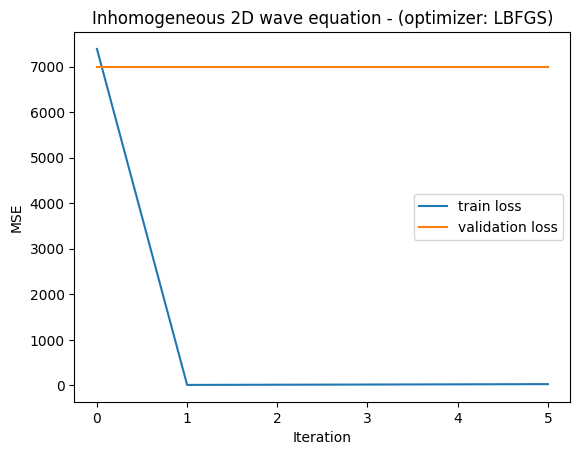

In [ ]:
#plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.title("Inhomogeneous 2D wave equation - (optimizer: LBFGS)")
plt.show()

In [ ]:
pinn.XY_c.shape

torch.Size([22500, 2])

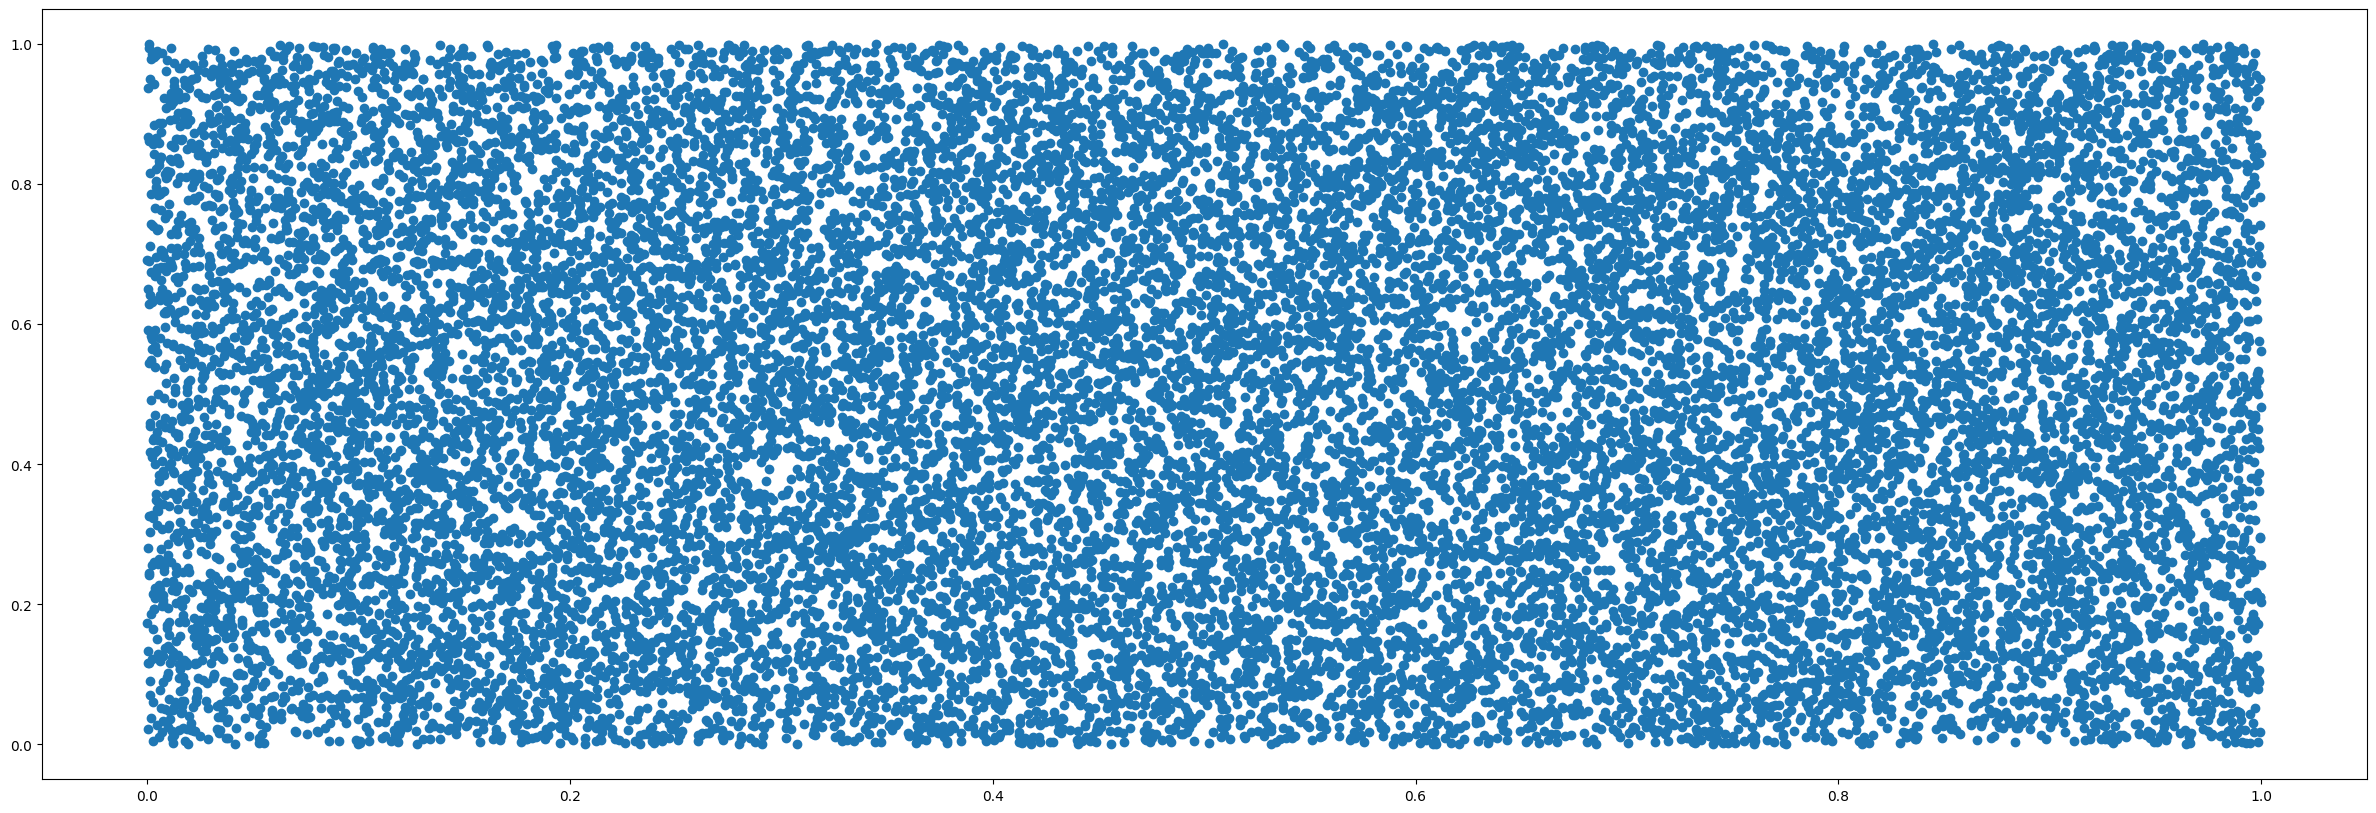

In [ ]:
plt.figure(figsize=(30, 10))
plt.scatter(pinn.XY_c[:, 0], pinn.XY_c[:, 1])

# INFERENCE

In [ ]:
# Load best model
print("Loading best model...")
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

# Get test input data
XY_test = pinn.XY_test
x_test = pinn.XY_test[:, 0].flatten()
x_test.requires_grad = True
y_test = pinn.XY_test[:, 1].flatten()
y_test.requires_grad = True

# Calculate real solution
u_test_real = list()
for i in range(XY_test.shape[0]):
  x, y = XY_test[i, 0], XY_test[i, 1]
  u = np.sin(4*np.pi*x) * np.sin(4*np.pi*y)
  u_test_real.append(u)

u_test_real = np.array(u_test_real)

# Calculate PINN's solution and 1st derivative to check initial conditions
u_test_pinn = pinn.feed_forward.forward(torch.cat((x_test.view(-1, 1), y_test.view(-1, 1)), dim=1)).flatten()
u_test_pinn_t = torch.autograd.grad(u_test_pinn, y_test, grad_outputs=torch.ones_like(u_test_pinn), create_graph=True)[0]
u_test_pinn = u_test_pinn.detach().numpy().flatten()
u_test_pinn_t = u_test_pinn_t.detach().numpy().flatten()

# Calculate NMSE (Normalized Mean Square Error)
test_error = u_test_real - u_test_pinn
test_nmse = np.linalg.norm(u_test_real - u_test_pinn, 2) / np.linalg.norm(u_test_real, 2)
print(f'Test NMSE: {test_nmse}')

# Turn off 'requires_grad' and turn pytorch tensors into numpy arrays
x_test.requires_grad_ = False
x_test = x_test.detach().numpy().flatten()
y_test.requires_grad_ = False
y_test = y_test.detach().numpy().flatten()

test_df = pd.DataFrame(
    {
        'y_test': y_test,
        'x_test': x_test,
        'u_test_real': u_test_real,
        'u_test_pinn': u_test_pinn
    }
)
test_df['abs_error'] = abs(test_df['u_test_real'] - test_df['u_test_pinn'])
test_df.to_csv('Inhomogeneous_wave_equation_results.csv', index=False)

Loading best model...
Test NMSE: 0.29955625534057617


# PLOTS

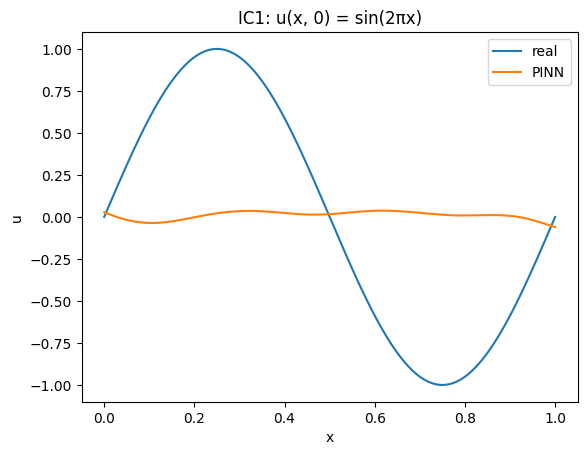

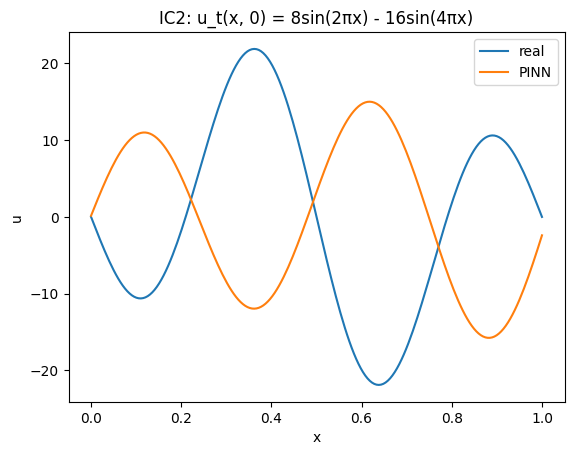

In [ ]:
# Get x's where t=0
t0_df = test_df[test_df['y_test'] == 0.0]
x_t0 = t0_df['x_test'].to_numpy().flatten()

# *** Check 1st Initial Condition ***
u_t0_pinn = t0_df['u_test_pinn'].to_numpy()
u_t0_real = np.sin(2*np.pi*x_t0)

plt.figure()
plt.plot(x_t0, u_t0_real, label='real')
plt.plot(x_t0, u_t0_pinn, label='PINN')
plt.xlabel("x")
plt.ylabel("u")
plt.title("IC1: u(x, 0) = sin(2πx)")
plt.legend()
plt.show()


# *** Check 2nd Initial Condition ***
pos_t0 = np.where(y_test == 0.0)
x_t0 = x_test[pos_t0]
t0 = y_test[pos_t0]
u_t_t0_pinn = u_test_pinn_t[pos_t0]
u_t_t0_real = 8*np.sin(2*np.pi*x_t0) - 16*np.sin(4*np.pi*x_t0)

plt.figure()
plt.plot(x_t0, u_t_t0_real, label='real')
plt.plot(x_t0, u_t_t0_pinn, label='PINN')
plt.xlabel("x")
plt.ylabel("u")
plt.title("IC2: u_t(x, 0) = 8sin(2πx) - 16sin(4πx)")
plt.legend()
plt.show()

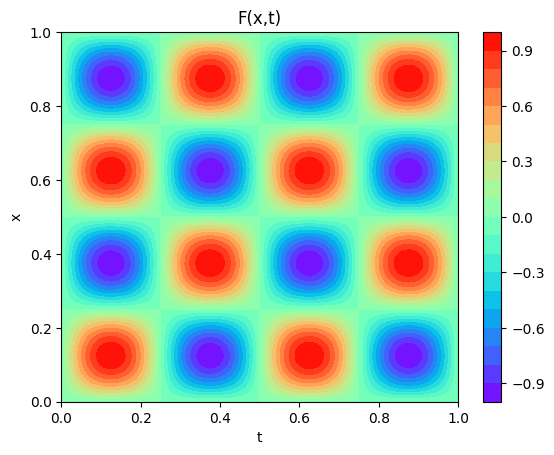

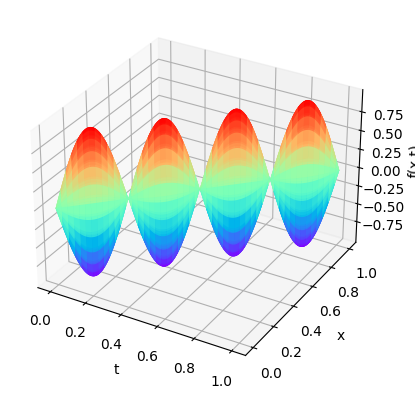

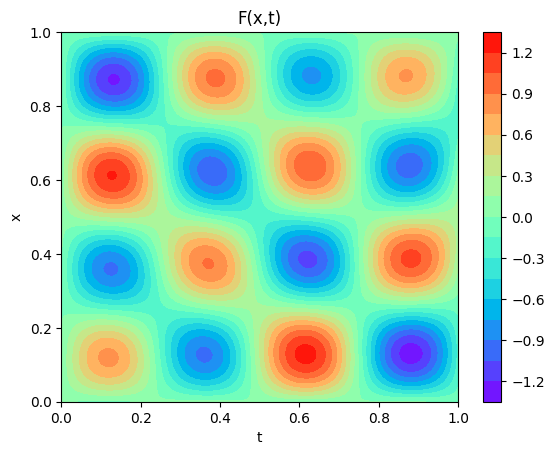

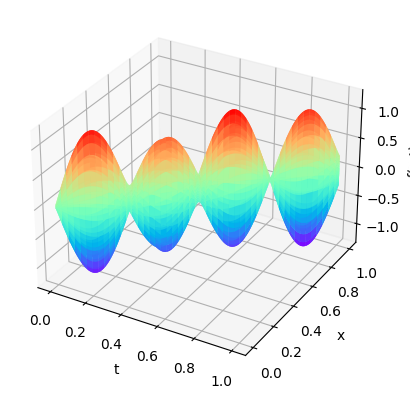

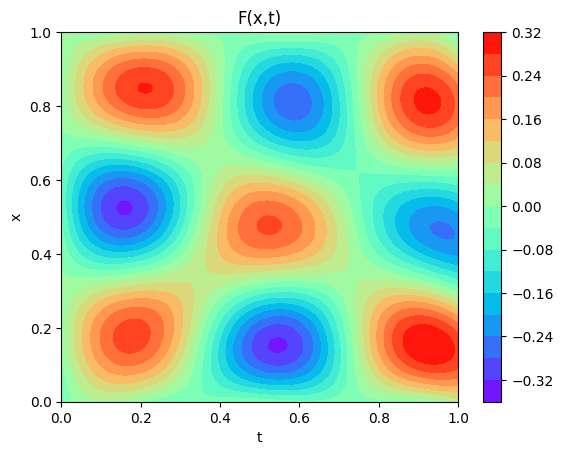

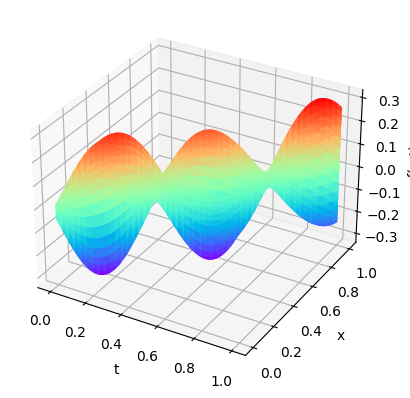

In [ ]:
x_test = pinn.xc
y_test = pinn.yc

u_test_real_2D = u_test_real.reshape(len(x_test), len(y_test))
u_test_pinn_2D = u_test_pinn.reshape(len(x_test), len(y_test))
test_error_2D = test_error.reshape(len(x_test), len(y_test))

plot3D(x_test, y_test, u_test_real_2D)
plot3D(x_test, y_test, u_test_pinn_2D)
plot3D(x_test, y_test, test_error_2D)